In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contextily as ctx  # For background map
from shapely.geometry import Point
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Methods

* Load & Clean Data – Ensure consistency between datasets
* Merge Data – If necessary, combine SHREGION (Senatorial districts), Region (States) and type of residence (ie urban or rural) information
* Exploratory Data Analysis (EDA) – Calculate mean prevalence per SHREGION and Region
* Visualizations – Use bar plots, line plots, and heatmaps
* Statistical Analysis (ANOVA & Tukey HSD) – Validate group differences

In [17]:
df_main  = pd.read_csv('Malaria screener.csv')
df_age  = pd.read_csv('Malaria data.csv')

In [18]:
# Merge if common columns exist
common_columns = list(set(df_main.columns) & set(df_age.columns))
if common_columns:
    df = pd.merge(df_main, df_age, on=common_columns, how='inner')
else:
    df = df_main  # Use main dataset if merging is not possible

In [19]:
# Merge datasets (if necessary)
if 'ID' in df_main.columns and 'ID' in df_age.columns:
    df = pd.merge(df_main, df_age, on='ID', how='inner')  # Merge on ID
else:
    df = pd.concat([df_main, df_age], axis=1)  # Merge by column order

In [20]:
# Convert columns to numeric, forcing non-numeric values to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' turns non-numeric values into NaN

In [21]:
# Fill NaN with Normal Distribution (Mean & Std)
for col in df.columns:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = df[col].apply(lambda x: np.random.normal(mean_val, std_val) if pd.isna(x) else x)

In [22]:
# Select relevant columns
selected_columns = ['Region','SHREGION','Type of place of residence','Malaria_Prevalence_2020']

# Check for missing values in the selected columns
missing_values = df[selected_columns].isnull().sum()
df = df[selected_columns].dropna()

# Display summary of the cleaned dataset
df.describe(), missing_values

(             Region      SHREGION  Type of place of residence  \
 count  70428.000000  70428.000000                70428.000000   
 mean      16.982195      3.208568                    1.676350   
 std       10.761770      1.634262                    0.467871   
 min        1.000000      1.000000                    1.000000   
 25%        8.000000      2.000000                    1.000000   
 50%       15.000000      3.000000                    2.000000   
 75%       26.000000      5.000000                    2.000000   
 max       37.000000      6.000000                    2.000000   
 
        Malaria_Prevalence_2020  
 count             70428.000000  
 mean                  0.271717  
 std                   0.128540  
 min                  -0.331990  
 25%                   0.185128  
 50%                   0.271705  
 75%                   0.358197  
 max                   0.798800  ,
 Region                        0
 SHREGION                      0
 Type of place of residence    

In [23]:
# Compute mean malaria prevalence for each group
grouped_data = df.groupby(['Region', 'SHREGION','Type of place of residence'])['Malaria_Prevalence_2020'].mean().reset_index()
grouped_data.rename(columns={'Malaria_Prevalence_2020': 'Average_Prevalence'}, inplace=True)
print("\nSummary Statistics:\n", grouped_data)


Summary Statistics:
     Region  SHREGION  Type of place of residence  Average_Prevalence
0        1         3                           1            0.269396
1        1         3                           2            0.268680
2        2         3                           1            0.269767
3        2         3                           2            0.272239
4        3         3                           1            0.260278
..     ...       ...                         ...                 ...
69      35         5                           2            0.270714
70      36         6                           1            0.267631
71      36         6                           2            0.267541
72      37         6                           1            0.262001
73      37         6                           2            0.270597

[74 rows x 4 columns]


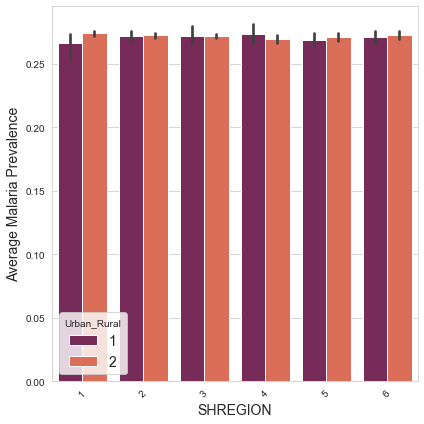

In [24]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='SHREGION', hue= 'Type of place of residence', palette='rocket')
#plt.title('Malaria Prevalence Trends')
plt.xlabel('SHREGION', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    Malaria prevalence trends across senatorial zones

* The bar and line plots reveal zones with higher prevalence.
* Differences between urban and rural prevalence are visualized.
* 1 = urban; 2 = rural
* Senatorial zones: 1 = North central, 2 = North east, 3 = North west, 4 = South east, 5 = South south, 6 = South west

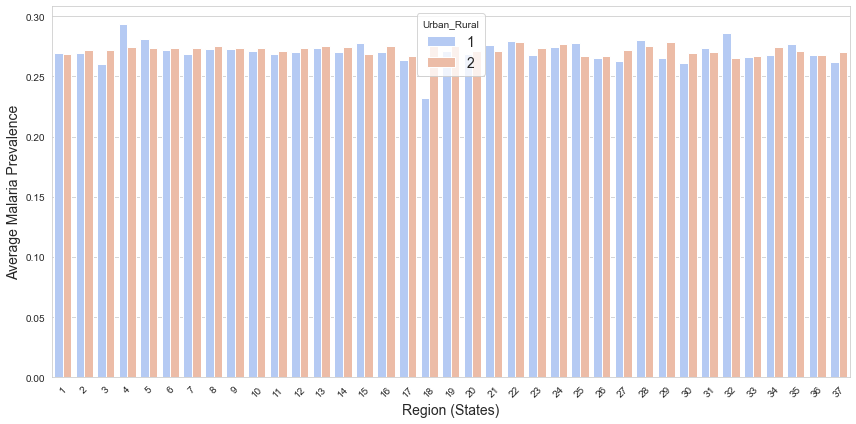

In [28]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='Region', hue= 'Type of place of residence', palette='coolwarm')
#plt.title('Malaria Prevalence Trends')
plt.xlabel('Region (States)', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

     Malaria prevalence trends across States and urban-rural differences

* The bar and line plots reveal States with higher prevalence.
* Differences between urban and rural prevalence are visualized.
* 1 = urban; 2 = rural
* States: 1=Sokoto, 2=Zamfara, 3=Katsina, 4=Jigawa, 5=Yobe, 6=Borno, 7=Adamawa, 8=Gombe, 9=Bauchi, 10=Kano, 11=Kaduna, 12=Kebbi,
    13=Niger, 14=FCT, 15=Nasarawa, 16=Plateau, 17=Taraba, 18=Benue, 19=Kogi, 20=Kwara, 21=Oyo, 22=Osun, 23=Ekiti, 24=Ondo,
    25=Edo, 26=Anambra, 27=Enugu, 28=Ebonyi. 29=Cross River, 30=Akwa Ibom, 31=Abia, 32=Imo, 33=Rivers, 34=Bayelsa, 
    35=Delta, 36=Lagos, 37=Ogun

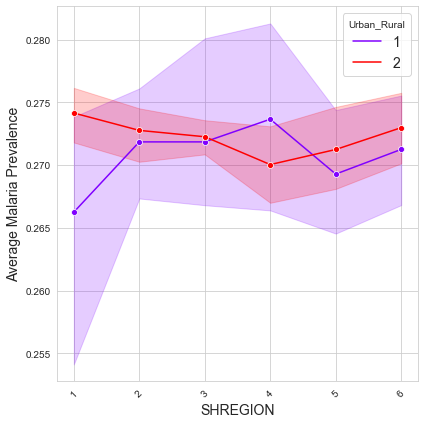

In [29]:
plt.figure(figsize=(6, 6))
sns.lineplot(data=grouped_data, x='SHREGION', y='Average_Prevalence', hue='Type of place of residence', marker='o', palette='rainbow')
#plt.title('Trends in Malaria Prevalence')
plt.xlabel('SHREGION', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   Trends in Malaria Prevalence by Senatorial zones and Type of place of residence

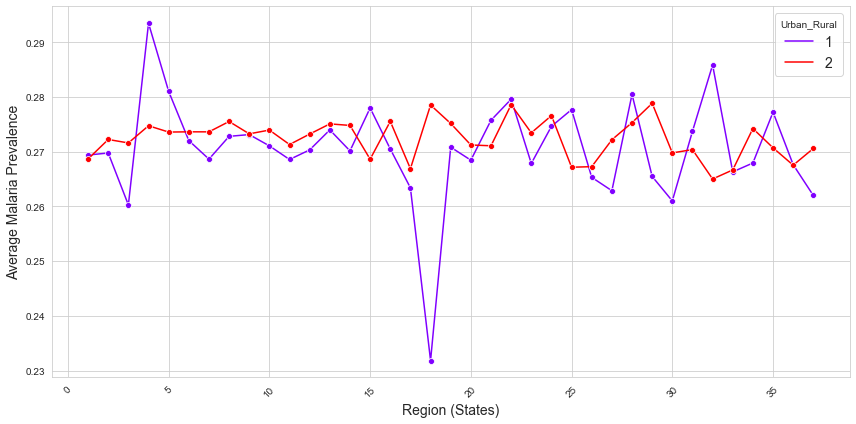

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='Region', y='Average_Prevalence', hue='Type of place of residence', marker='o', palette='rainbow')
#plt.title('Trends in Malaria Prevalence')
plt.xlabel('Region (States)', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  Trends in Malaria Prevalence by States and Types of place of residence

ANOVA Results

* Tests if malaria prevalence differs significantly across states, type of place of residence and zones.
* A p-value < 0.05 suggests significant differences.

In [31]:
# ANOVA Test
anova_data = df.groupby(['SHREGION', 'Region', 'Type of place of residence'])['Malaria_Prevalence_2020']
groups = [values for (_, _, _), values in anova_data]

f_stat, p_value = f_oneway(*groups)
print("\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant differences exist.")
else:
    print("No significant differences found.")


ANOVA Results:
F-statistic: 1.7203, P-value: 1.2993e-04
Statistically significant differences exist.


Tukey HSD (Post-Hoc Test)

* Identifies which specific groups are significantly different.
* The heatmap visualizes these differences.

In [32]:
# Post-Hoc Analysis (Tukey HSD)

df['Group_Label'] = df['SHREGION'].astype(str) + ", " + df['Type of place of residence'].astype(str) + ", " + df['Region'].astype(str)
tukey = pairwise_tukeyhsd(df['Malaria_Prevalence_2020'], df['Group_Label'], alpha=0.05)
print("\nTukey HSD Results:\n", tukey)


Tukey HSD Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
1, 1, 13 1, 1, 14  -0.0038    0.9  -0.031  0.0233  False
1, 1, 13 1, 1, 15    0.004    0.9 -0.0255  0.0336  False
1, 1, 13 1, 1, 16  -0.0035    0.9 -0.0328  0.0258  False
1, 1, 13 1, 1, 18  -0.0422  0.001 -0.0734 -0.0109   True
1, 1, 13 1, 1, 19  -0.0032    0.9 -0.0358  0.0295  False
1, 1, 13 1, 1, 20  -0.0055    0.9 -0.0347  0.0236  False
1, 1, 13 1, 2, 13   0.0011    0.9 -0.0221  0.0243  False
1, 1, 13 1, 2, 14   0.0008    0.9 -0.0288  0.0304  False
1, 1, 13 1, 2, 15  -0.0054    0.9 -0.0294  0.0187  False
1, 1, 13 1, 2, 16   0.0016    0.9 -0.0233  0.0264  False
1, 1, 13 1, 2, 18   0.0045    0.9 -0.0194  0.0284  False
1, 1, 13 1, 2, 19   0.0012    0.9 -0.0235  0.0258  False
1, 1, 13 1, 2, 20  -0.0028    0.9 -0.0299  0.0244  False
1, 1, 13 2, 1, 17  -0.0106    0.9 -0.0443  0.0231  False
1, 1, 13  

* group1: First comparison group (e.g., urban, 1-6)

* group2: Second comparison group (e.g., rural, 1-6)

* meandiff: Difference in mean malaria prevalence between group1 and group2

* p-adj Adjusted p-value (If < 0.05, the difference is significant)

* lower: Lower bound of the confidence interval

* upper: Upper bound of the confidence interval

* reject: True if the difference is statistically significant, otherwise False

Significant Differences (reject = True and p-adj < 0.05):

* Groups with significant malaria prevalence differences can be identified.

* Example: If Urban, 0-5 and Rural, 0-5 have reject = True, it means Type of place of residence impacts prevalence in this age group.

Non-Significant Differences (reject = False and p-adj > 0.05):

* If a comparison has a high p-value, there is no strong evidence that malaria prevalence differs in those groups.

Effect Size (meandiff):

* Large positive values mean group1 has higher malaria prevalence.

* Large negative values mean group2 has higher malaria prevalence.

In [33]:
tukey_results = pd.DataFrame(data=tukey._results_table.data[1:], 
                             columns=tukey._results_table.data[0])

In [34]:
# Create a heatmap of p-values
tukey_pivot = tukey_results.pivot(index='group1', columns='group2', values='p-adj')

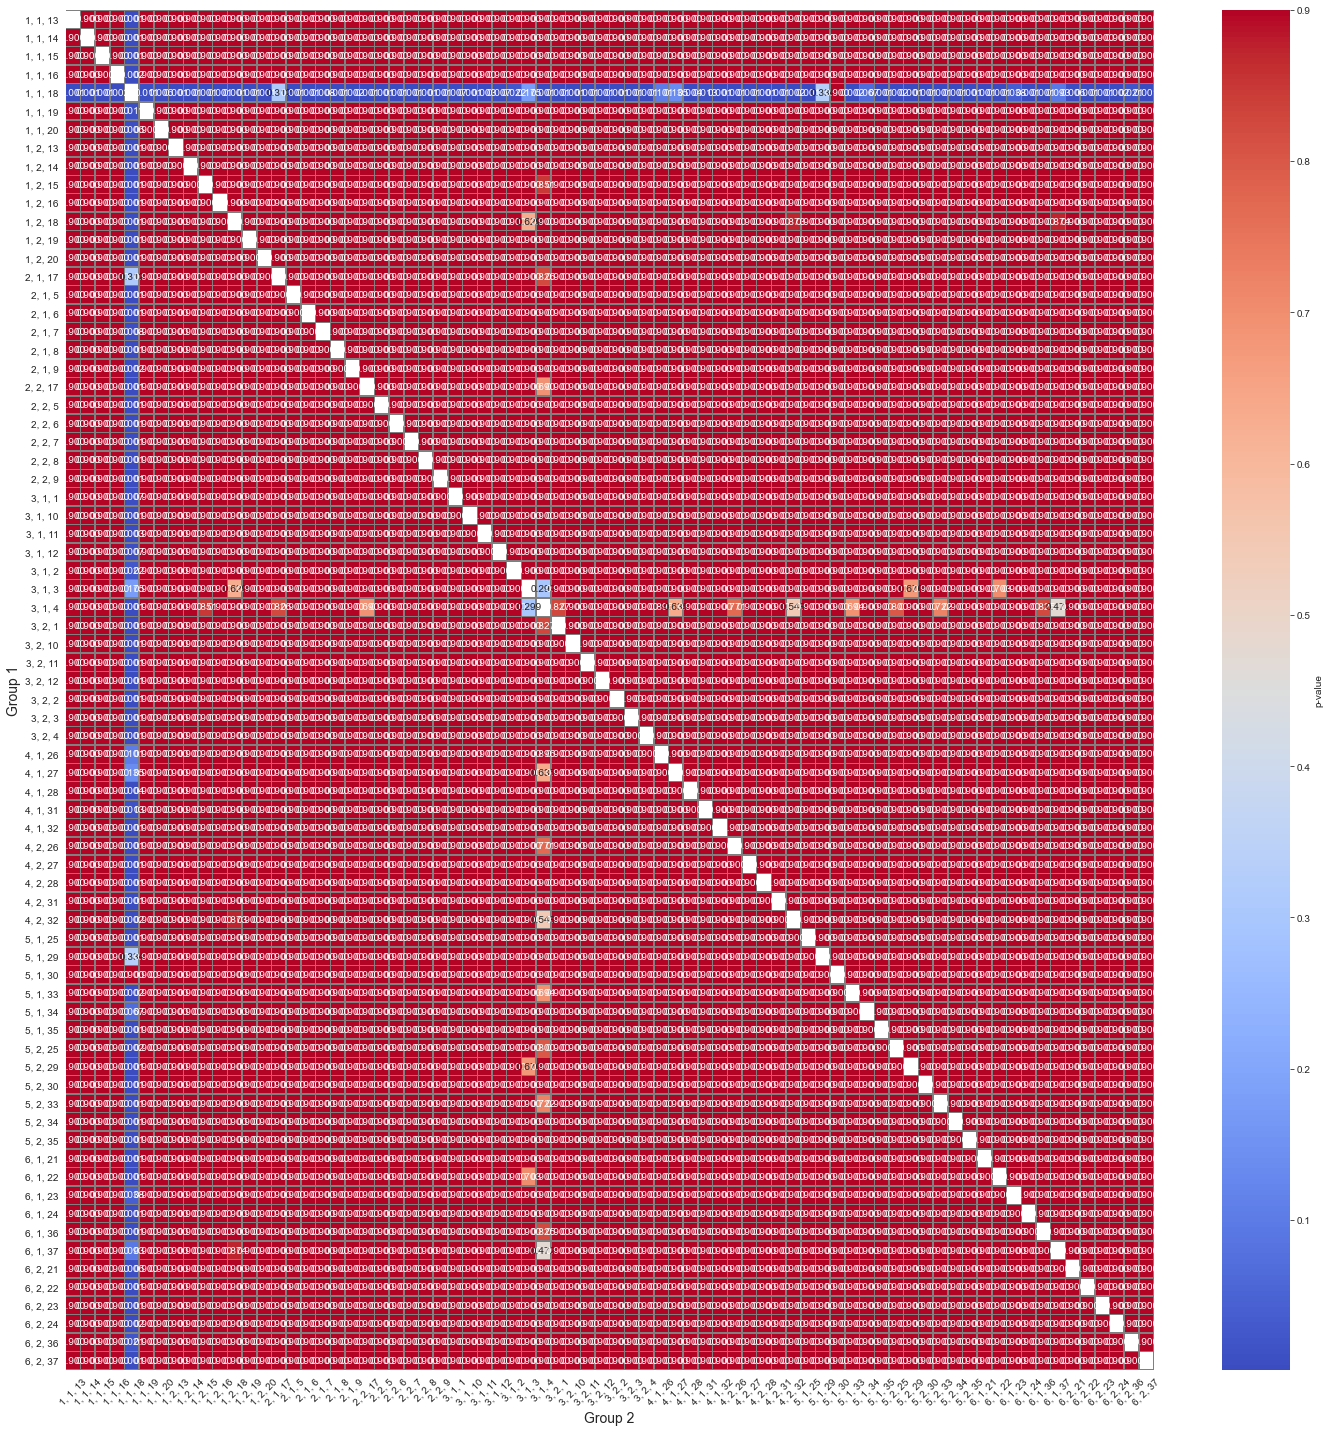

In [35]:
# Sort Tukey results for better visualization
tukey_results_sorted = tukey_results.sort_values(by=['p-adj'])

# Create a pivot table for heatmap (p-values)
tukey_pivot_pval = tukey_results.pivot(index='group1', columns='group2', values='p-adj')
tukey_pivot_meandiff = tukey_results.pivot(index='group1', columns='group2', values='meandiff')

# Ensure the heatmaps are symmetrical for better interpretation
tukey_pivot_pval = tukey_pivot_pval.combine_first(tukey_pivot_pval.T)
tukey_pivot_meandiff = tukey_pivot_meandiff.combine_first(-tukey_pivot_meandiff.T)

# Plot p-value heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(tukey_pivot_pval, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'p-value'},
            linewidths=0.5, linecolor='gray')
#plt.title('Tukey HSD - Pairwise Comparisons (p-values)')
plt.xlabel('Group 2', fontsize=14)
plt.ylabel('Group 1', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

  Tukey HSD - Pairwise Comparisons (p-values)

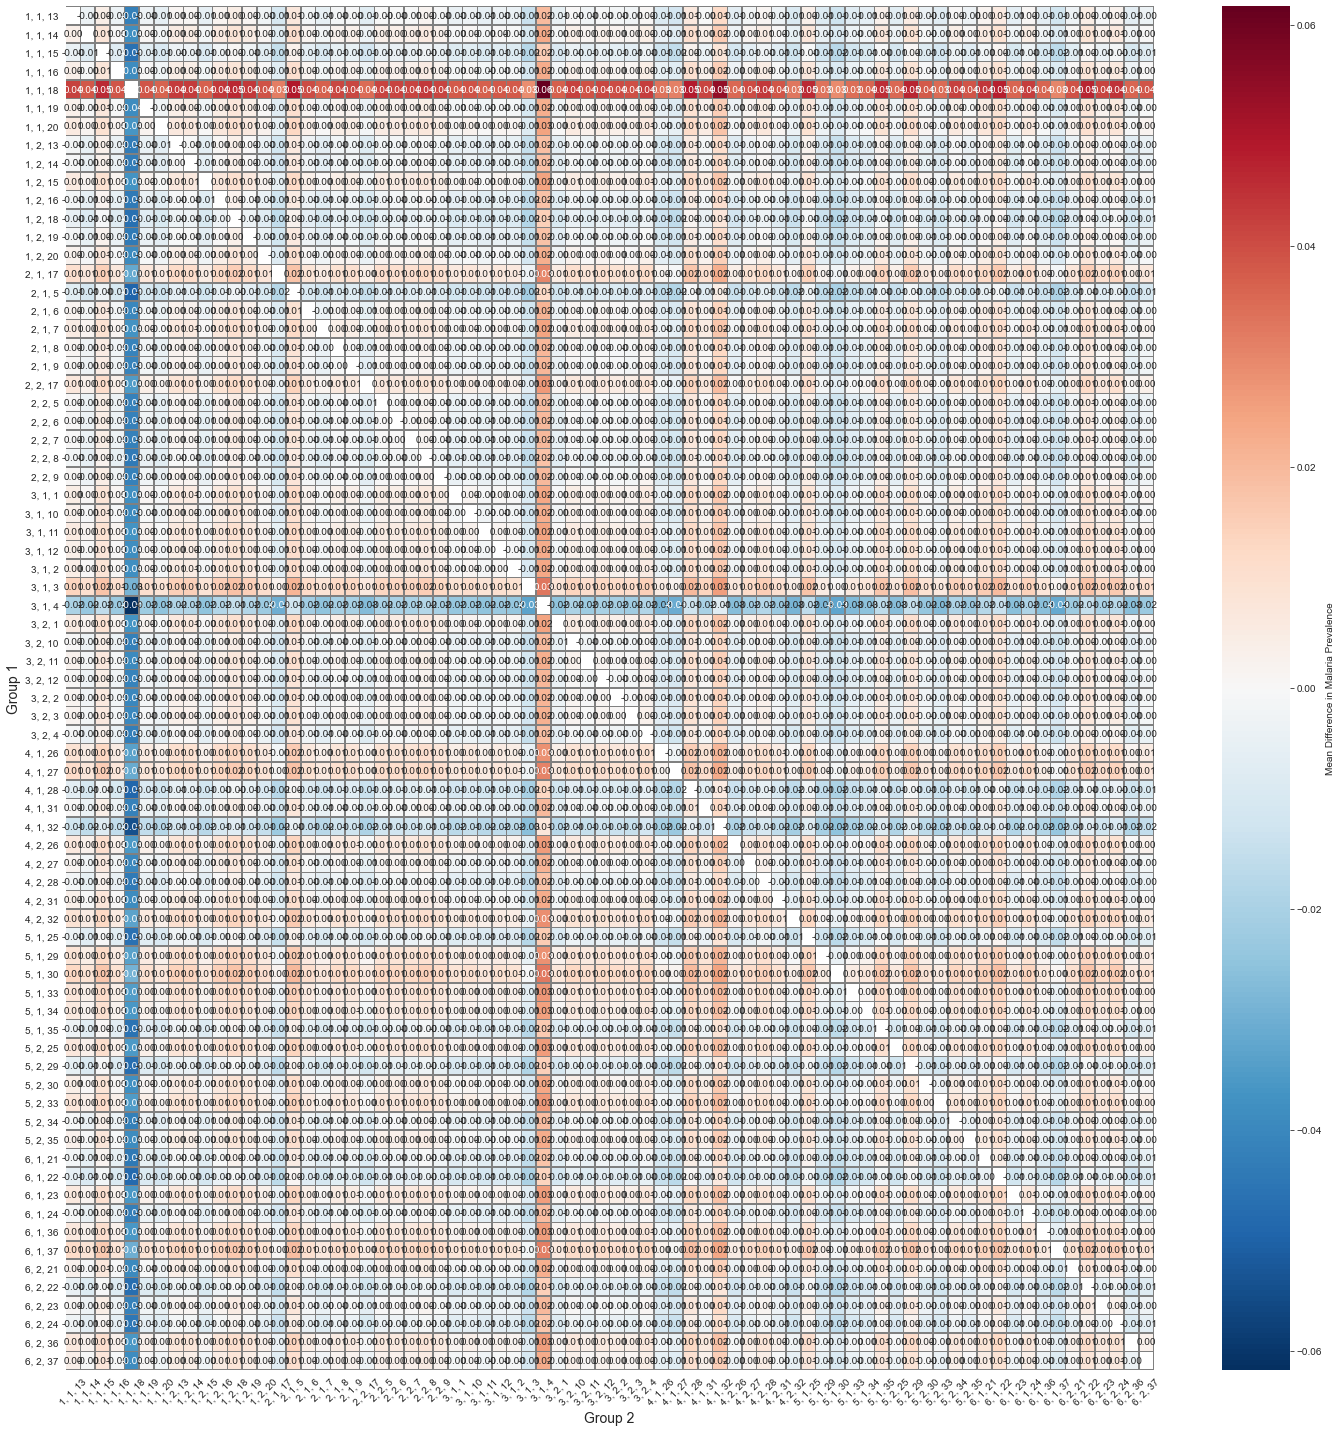

In [36]:
# Plot Mean Difference Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(tukey_pivot_meandiff, annot=True, fmt=".2f", cmap='RdBu_r', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Mean Difference in Malaria Prevalence'})
#plt.title('Tukey HSD - Mean Differences Between Groups')
plt.xlabel('Group 2', fontsize=14)
plt.ylabel('Group 1', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

 Tukey HSD - Mean Differences Between Groups

P-Value Heatmap (Significance of Differences)

* Dark blue (low p-values) → Strong evidence of differences.
* Red/white (high p-values) → No significant difference.
* Mean Difference Heatmap (Effect Size)

Deep red values → Group 1 has much higher malaria prevalence.
* Deep blue values → Group 2 has much higher malaria prevalence.
* White (near 0) → Groups have similar prevalence.